Python Notebook to implement SCALe algorithm on Salinas dataset.

# Import Packages

In [1]:
import numpy as np
import random
import pandas as pd
from scipy import stats
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.special import jacobi
from scipy.special import loggamma
import copy
from sklearn import metrics
import csv

# Import and Setup Data

Execute next 3 cells only if generating new data.

In [2]:
import os
import scipy.io as sio
import numpy as np

# Directory where your .mat files are located
DATA_DIR = r"C:\Users\ryanm\OneDrive\Documents\Python\Classification\Salinas Hyperspectral"

def load_mat_file(filename):
    filepath = os.path.join(DATA_DIR, filename)
    data = sio.loadmat(filepath)
    return data

# Load Indian Pines dataset
# indian_pines_data = load_mat_file("Indian_pines_corrected.mat")
# print("Keys in Indian Pines .mat file:", indian_pines_data.keys())

# Load Salinas dataset
salinas_data = load_mat_file("Salinas_corrected.mat")
print("Keys in Salinas .mat file:", salinas_data.keys())

# Example to access the hyperspectral data
# (You'll need to inspect the keys to identify the correct variable names)
# indian_pines_hsi = indian_pines_data.get('indian_pines_corrected')  # Replace with actual key if different
salinas_hsi = salinas_data.get('salinas')  # Replace with actual key if different

# Check the shapes of the datasets
# if indian_pines_hsi is not None:
#     print("Indian Pines Data Shape:", indian_pines_hsi.shape)
# else:
#     print("Hyperspectral data key not found in Indian Pines file.")

if salinas_hsi is not None:
    print("Salinas Data Shape:", salinas_hsi.shape)
else:
    print("Hyperspectral data key not found in Salinas file.")


Keys in Salinas .mat file: dict_keys(['__header__', '__version__', '__globals__', 'salinas_corrected'])
Hyperspectral data key not found in Salinas file.


In [ ]:
import os
import scipy.io as sio
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

def load_mat_file(filename):
    filepath = os.path.join(DATA_DIR, filename)
    data = sio.loadmat(filepath)
    return data

# Load Salinas dataset and ground truth
salinas_data = load_mat_file("Salinas_corrected.mat")
salinas_hsi = salinas_data.get('salinas_corrected')
salinas_gt = load_mat_file("Salinas_gt.mat").get('salinas_gt')

# === Step 2: Normalization ===
def normalize_data(hsi_data):
    scaler = MinMaxScaler()
    reshaped_data = hsi_data.reshape(-1, hsi_data.shape[2])
    normalized_data = scaler.fit_transform(reshaped_data)
    return normalized_data.reshape(hsi_data.shape)

salinas_hsi = normalize_data(salinas_hsi)

# === Step 3: Reshape Data for ML ===
def reshape_for_ml(hsi_data):
    return hsi_data.reshape(-1, hsi_data.shape[2])

salinas_ml = reshape_for_ml(salinas_hsi)
salinas_labels = salinas_gt.flatten()

# === Step 4: Filter First 6 Classes ===
def filter_first_six_classes(data, labels):
    mask = np.isin(labels, np.arange(1, 11))  # Keep classes 1 to 6
    return data[mask], labels[mask]

salinas_ml, salinas_labels = filter_first_six_classes(salinas_ml, salinas_labels)

# === Step 5: Stratified Sampling (~1/3 of each class) ===
def stratified_sampling(data, labels, fraction=1/2):
    sampled_data = []
    sampled_labels = []
    
    unique_classes = np.unique(labels)
    for cls in unique_classes:
        class_indices = np.where(labels == cls)[0]
        num_samples = int(len(class_indices) * fraction)
        
        # Randomly sample indices for the current class
        sampled_indices = np.random.choice(class_indices, size=num_samples, replace=False)
        
        sampled_data.append(data[sampled_indices])
        sampled_labels.append(labels[sampled_indices])
    
    # Concatenate results from all classes
    return np.vstack(sampled_data), np.concatenate(sampled_labels)

# Apply stratified sampling
sampled_data, sampled_labels = stratified_sampling(salinas_ml, salinas_labels)

# === Step 6: Apply PCA ===
def apply_pca(hsi_data, n_components=50):
    pca = PCA(n_components=n_components, whiten=True)
    reduced_data = pca.fit_transform(hsi_data)
    return reduced_data

X_pca_salinas = apply_pca(sampled_data)

# === Step 7: Final Outputs ===
classes_salinas = np.sort(np.unique(sampled_labels))

print(f"Original Dataset Shape: {salinas_ml.shape}")
print(f"Sampled Dataset Shape: {sampled_data.shape}")
print(f"Salinas PCA Shape: {X_pca_salinas.shape}")
print(f"Classes After Sampling: {classes_salinas}")


# Display class distribution after sampling (Clean Output)
unique, counts = np.unique(sampled_labels, return_counts=True)
class_distribution = dict(zip(unique.tolist(), counts.tolist()))  # Convert to plain Python types

print(f"Class Distribution After Sampling: {class_distribution}")



In [ ]:
train=X_pca_salinas
target=sampled_labels

Execute next 2 cells only if loading previously generated data.

In [2]:
with open("train_salinas_half_10class.csv", 'r') as x:
    sample_data = list(csv.reader(x, delimiter=","))
train = np.array(sample_data)[1:20035].astype(float)
print(train,np.shape(train))

[[ 1.99979847 -0.72274509 -1.22112664 ...  0.52875176 -1.55042951
   0.87423872]
 [ 1.80382465 -0.40759556 -1.04130601 ...  0.97428594  0.48191141
   1.10969247]
 [ 1.93074712 -0.55734316 -1.28452244 ... -0.9156962   0.43583374
  -0.65388899]
 ...
 [-0.94668587 -0.98060242 -0.45060834 ...  1.4347525   0.25964165
   0.25810408]
 [-0.92210224 -0.84821505 -0.32175008 ... -2.32313729  0.01304315
  -0.09601455]
 [-0.89657975 -0.77119052 -0.26675822 ...  1.0386675   1.95054709
   1.50077064]] (20034, 50)


In [3]:
with open("target_salinas_half_10class.csv", 'r') as x:
    sample_data = list(csv.reader(x, delimiter=","))
 
target = np.array(sample_data)[1:20035].reshape((20034,)).astype(int)
print(np.shape(target))


(20034,)


Get size of training set and classes. Print number of points belonging to each class.

In [4]:
trainsize=len(train[:,0])
classes=np.sort(list(dict.fromkeys(target)))
print(f"Vector of class labels: {classes}")
for i in np.arange(1,11):
    print(f"Number of points in class {i}: {len(np.where(target==i)[0])}")

Vector of class labels: [ 1  2  3  4  5  6  7  8  9 10]
Number of points in class 1: 1004
Number of points in class 2: 1863
Number of points in class 3: 988
Number of points in class 4: 697
Number of points in class 5: 1339
Number of points in class 6: 1979
Number of points in class 7: 1789
Number of points in class 8: 5635
Number of points in class 9: 3101
Number of points in class 10: 1639


Define Data matrices on the sphere.

1.0 0.15217174671762287
1.4180310870621375 0.0


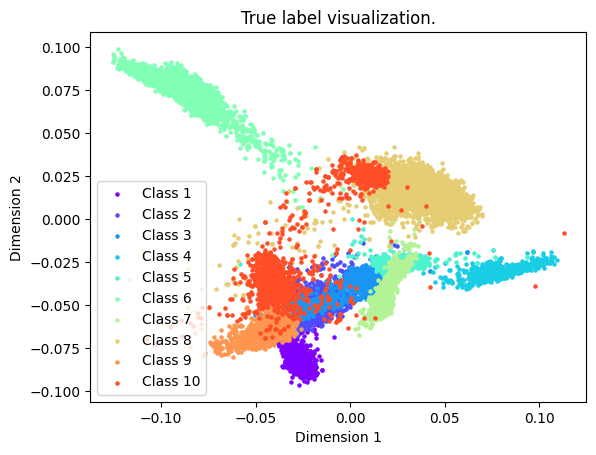

In [5]:
# #Translate Training Data to have range centered at zero
avg=(np.max(train, axis=0)+np.min(train, axis=0))/2
traincen=train-avg

#traincen=svdtrain

#Project Data to the sphere with hyperparameter alpha in (0,2]
alpha=1
maxnorm=np.max(np.linalg.norm(traincen, axis=1))
scaledtrain=alpha*traincen/maxnorm #1.5 can be changed to any value <=2 to control spread of data
r=np.linalg.norm(scaledtrain, axis=1)
trainsph=np.hstack((((4*(scaledtrain.T*r).T).T/((4+r**2)*r)).T,((4-r**2)/(4+r**2)).reshape(trainsize,1)))
normsph=np.linalg.norm(trainsph, axis=1)

#Matrix of angles between points
sphmat=np.matmul(trainsph,np.transpose(trainsph))
#this line is for slight rounding error causing out-of-bounds for arccos
sphmat[sphmat>1]=1

#Matrix of spherical distance between points
distmat=np.arccos(sphmat)
print(sphmat.max(),sphmat.min())
print(distmat.max(),distmat.min())

c=cm.rainbow(np.linspace(0,1,len(classes)+1))
for i in classes:
    plt.scatter(trainsph[np.where(target==i)[0],1],trainsph[np.where(target==i)[0],2],s=5,color=c[i-1],label=f"Class {i}")
plt.title('True label visualization.')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

# Show the plot
plt.show()

# Define Localized Kernels

Positive Chebyshev Kernel for use with support estimation. Included is a piecewise linear estimation of the kernel for improved run-times.

<>:44: SyntaxWarning: invalid escape sequence '\P'
<>:45: SyntaxWarning: invalid escape sequence '\P'
<>:44: SyntaxWarning: invalid escape sequence '\P'
<>:45: SyntaxWarning: invalid escape sequence '\P'
C:\Users\ryanm\AppData\Local\Temp\ipykernel_14440\822943701.py:44: SyntaxWarning: invalid escape sequence '\P'
  plt.plot(testdomain,Phiapproxgraph, c='b', label="$\Phi$ approximation")
C:\Users\ryanm\AppData\Local\Temp\ipykernel_14440\822943701.py:45: SyntaxWarning: invalid escape sequence '\P'
  plt.plot(testdomain,Phimat, c='r', label="$\Phi$ Actual")


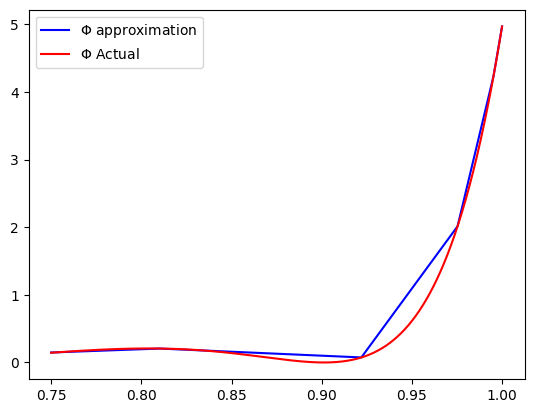

In [6]:
#defining the half-pass filter
def h(t):
    t = np.abs(t)
    out = np.zeros_like(t)
    for i in range(len(t)):
        if t[i] <= 1/2:
            out[i] = 1
        elif (1/2 < np.abs(t[i])) and (np.abs(t[i]) < 1):
            out[i] = np.exp(-np.exp(2/(1-2*t[i]))/(1-t[i]))
        else:
            out[i] = 0
    return out

#Phi Kernel Definition
def Phi(n,x):
    out=1/(2*np.pi)
    for k in np.arange(1,n,1):
        out+=h([k/n])*np.cos(k*np.arccos(x))/np.pi
    out=out**2
    return out

def Phiapprox(n,x,numinterp):
    xdir=x.shape[0]
    if x.ndim==1:
        ydir=1
    if x.ndim==2:
        ydir=x.shape[1]
    xlist=np.vstack((x.reshape(1,xdir*ydir),np.arange(xdir*ydir)))
    phivals=1-2*(1/2-np.linspace(-1,1,numinterp)/2)**(n/2)
    phivec=Phi(n,phivals)
    newmat=np.zeros((xdir*ydir,1))
    for i in np.arange(1,numinterp,1):
        ind=xlist[0]<=phivals[i]
        newmat[xlist[1][ind].astype(int)]=(phivec[i-1]+(xlist[0][ind]-phivals[i-1])*(phivec[i]-phivec[i-1])/(phivals[i]-phivals[i-1])).reshape(ind.sum(),1)
        xlist=np.delete(xlist, ind, 1)
    newmat=np.reshape(newmat,(xdir,ydir))
    return newmat

n=8
testdomain=np.linspace(.75,1,10000)
Phimat=Phi(n,testdomain)
Phiapproxgraph=Phiapprox(n,testdomain,10)

plt.plot(testdomain,Phiapproxgraph, c='b', label="$\Phi$ approximation")
plt.plot(testdomain,Phimat, c='r', label="$\Phi$ Actual")
plt.legend()

Non-positive ultraspherical-polynomial kernel for witness function extension.

In [7]:
#Normalization for Jacobi Polynomials
def normalize(n,alpha,beta):
    out=2**(alpha+beta+1)*np.exp(loggamma(n+alpha+1)+loggamma(n+beta+1)-loggamma(n+1)-loggamma(n+alpha+beta+1))/(2*n+alpha+beta+1)
    return out

#Phi Kernel Definition
def Phiq(n,q,x):
    out=0
    for k in np.arange(0,n,1):
        out+=h([k/n])*jacobi(k,q/2-1,q/2-1)(1)*jacobi(k,q/2-1,q/2-1)(x)/normalize(k,q/2-1,q/2-1)
    return out

def Phiqapprox(n,q,x,numinterp):
    xdir=x.shape[0]
    if x.ndim==1:
        ydir=1
    if x.ndim==2:
        ydir=x.shape[1]
    xlist=np.vstack((x.reshape(1,xdir*ydir),np.arange(xdir*ydir)))
    phivals=1-2*(1/2-np.linspace(-1,1,numinterp)/2)**(n/2)
    phivec=Phiq(n,q,phivals)
    newmat=np.zeros((xdir*ydir,1))
    for i in np.arange(1,numinterp,1):
        ind=xlist[0]<=phivals[i]
        newmat[xlist[1][ind].astype(int)]=(phivec[i-1]+(xlist[0][ind]-phivals[i-1])*(phivec[i]-phivec[i-1])/(phivals[i]-phivals[i-1])).reshape(ind.sum(),1)
        xlist=np.delete(xlist, ind, 1)
    newmat=np.reshape(newmat,(xdir,ydir))
    return newmat

# SCALe Algorithm

Generate Phimat matrix for thresholding and querying.

In [ ]:
n=128

#Phi function
#Phimat=Phi(n,sphmat)
#Phisum=np.sum(Phimat,axis=0)

Phimat=Phiapprox(n,sphmat,100)
Phisum=np.sum(Phimat,axis=0)

Theta thresholding.

In [1]:
Theta=.05

#percentage of data to be captured
datathreshold=1
verticescount=0

while verticescount<datathreshold*trainsize:
    Theta=Theta-.05
    vertex_list=np.where(Phisum>Theta*Phisum.max())[0]
    verticescount=len(vertex_list)
    

#distmat for only those points
distmat_sheared=distmat[vertex_list]
print(verticescount)

NameError: name 'trainsize' is not defined

Eta for loop of SCALe algorithm.

In [ ]:
predict_labels=np.zeros(trainsize)
A=[]
B=[]

for eta in np.arange(.21,.27,.01):
    #Adjacency matrix for sheared points
    adjmat=np.zeros([verticescount, verticescount])
    adjmat[distmat_sheared<eta]=1
    adjmat=adjmat-np.identity(len(vertex_list))

    #Compute Graph components
    graph=csr_matrix(adjmat)
    num_components, componentlist = connected_components(csgraph=graph, directed=False, return_labels=True)

    #Trim components. Any components of size smaller than this value will be removed from list by setting their component to -1
    componentthreshold=3
    componentnum, componentsizes=np.unique(componentlist, return_counts="True")
    bigcomponents=np.where(componentsizes>componentthreshold)[0]
    sheared_componentlist=componentlist[np.isin(componentlist,bigcomponents)]
    sheared_componentnum, sheared_componentsizes=np.unique(sheared_componentlist, return_counts="True")

    #Find modal points in each cluster to query true class label. keep track of x_i and y_i from each.
    for i in sheared_componentnum: # np.arange(0,num_components):
        componentset=vertex_list[np.where(componentlist==i)[0]]
        if np.intersect1d(A,componentset).size==0:

            x_i=componentset[np.argmax(Phisum[componentset])]
            y_i=target[x_i]
            A.append(x_i)
            B.append(y_i)
            predict_labels[componentset]=y_i

            #uncomment this code and comment the above code to query multiple points per cluster
            # querysize=np.max((round(componentset.size*.05),1))
            # queryargs=np.argpartition(Phisum[componentset], -querysize)[-querysize:]
            # modalpoint=stats.mode(target[componentset[queryargs]])[0]
            # y_i=modalpoint
            # for x_i in componentset[queryargs]:
            #     A.append(x_i)
            #     B.append(target[x_i])
            #     predict_labels[x_i]=target[x_i]
            # predict_labels[np.setdiff1d(componentset,componentset[queryargs])]=y_i
            
        elif np.size(np.unique(np.intersect1d(A,componentset)))==1:
            predict_labels[componentset]=target[np.unique(np.intersect1d(A,componentset))[0]]
            



predict_labels_ind=np.where(predict_labels)[0]
truthcheck=target[predict_labels_ind].T==predict_labels[predict_labels_ind]

print(f"List of classes in the prediction: {np.setdiff1d(list(dict.fromkeys(predict_labels)),[0])}")
print(f"Number of points queried: {len(A)}")
predict_labels_ind=np.where(predict_labels)[0]
truthcheck=target[predict_labels_ind]==predict_labels[predict_labels_ind]
correctnum=len(np.where(truthcheck)[0])
totalnum=len(predict_labels_ind)
print(f"Number of points classified: {totalnum}")
print(f"Number of correctly classified points of those classified: {correctnum} ({100*correctnum/totalnum:.2f}%)")

List of classes in the prediction: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Number of points queried: 261
Number of points classified: 1518
Number of correctly classified points of those classified: 1512 (99.60%)


Plot output from SCALe algorithm before witness function extension.

<>:7: SyntaxWarning: invalid escape sequence '\T'
<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\T'
<>:7: SyntaxWarning: invalid escape sequence '\e'
C:\Users\ryanm\AppData\Local\Temp\ipykernel_19628\425261125.py:7: SyntaxWarning: invalid escape sequence '\T'
  plt.title(f'Visualization of classification with n: {n}, $\Theta$: {Theta:.2f}, $\eta$={eta:.2f}.\n {len(A)} points queried. {totalnum}/{trainsize} points classified. \n {correctnum}/{totalnum} ({100*correctnum/totalnum:.2f}%) classified correctly.')
C:\Users\ryanm\AppData\Local\Temp\ipykernel_19628\425261125.py:7: SyntaxWarning: invalid escape sequence '\e'
  plt.title(f'Visualization of classification with n: {n}, $\Theta$: {Theta:.2f}, $\eta$={eta:.2f}.\n {len(A)} points queried. {totalnum}/{trainsize} points classified. \n {correctnum}/{totalnum} ({100*correctnum/totalnum:.2f}%) classified correctly.')


18516


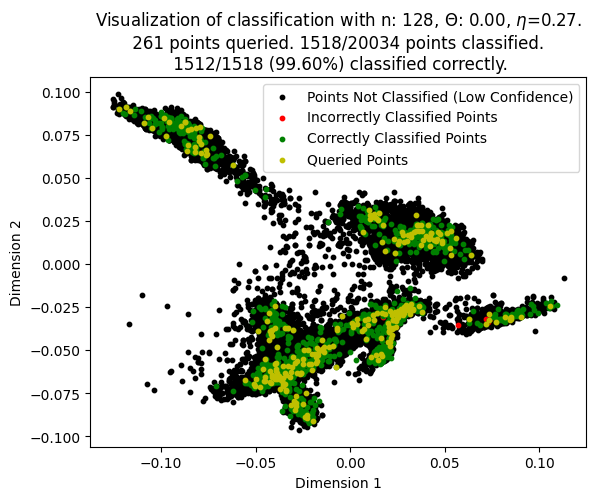

In [14]:
falsepoints=predict_labels_ind[np.where(truthcheck==False)[0]]
truepoints=predict_labels_ind[np.where(truthcheck)[0]]
plt.scatter(trainsph[np.setdiff1d(np.arange(0,trainsize),predict_labels_ind),1],trainsph[np.setdiff1d(np.arange(0,trainsize),predict_labels_ind),2],s=10,color="black", label=f"Points Not Classified (Low Confidence)")
plt.scatter(trainsph[falsepoints,1],trainsph[falsepoints,2],s=10,color="r",label=f"Incorrectly Classified Points")
plt.scatter(trainsph[np.setdiff1d(truepoints,A),1],trainsph[np.setdiff1d(truepoints,A),2],color="g",s=10,label=f"Correctly Classified Points")
plt.scatter(trainsph[A,1],trainsph[A,2],color="y",s=10,label=f"Queried Points")
plt.title(f'Visualization of classification with n: {n}, $\Theta$: {Theta:.2f}, $\eta$={eta:.2f}.\n {len(A)} points queried. {totalnum}/{trainsize} points classified. \n {correctnum}/{totalnum} ({100*correctnum/totalnum:.2f}%) classified correctly.')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

print(len(np.setdiff1d(np.arange(0,trainsize),predict_labels_ind)))

# Show the plot
plt.show()

# Witness Function

The cell below allows one to set a "quota" of data points to be queried to aid in witness function extension. These additional queries are not expected to improve accuracy much.

In [15]:
quota_percentage=.03
wit_A=copy.deepcopy(A)
wit_B=copy.deepcopy(B)
quota=np.round(trainsize*quota_percentage).astype(int)-len(A)
final_labels=copy.deepcopy(predict_labels)

if quota>=0:
    remainderpoints=np.where(predict_labels==0)[0]
    random_indicies=random.sample(sorted(remainderpoints), quota)
    for x_i in random_indicies:
        y_i=target[x_i]
        wit_A.append(x_i)
        wit_B.append(y_i)
        final_labels[x_i]=y_i
else:
    print("Error: Set A is already larger than this percentage")

Run witness function extension and output final accuracy on entire dataset.

In [16]:
dim=4
new_n=12

remainderpoints=np.where(final_labels==0)[0]
Phiqmat=Phiqapprox(new_n,dim,sphmat[:,remainderpoints],100)
labels=np.setdiff1d(np.sort(list(dict.fromkeys(final_labels))),[0])

#initialization of clusters and witness function
S=[]
witness=[]
Phimat_sheared=Phiqmat
for i in np.arange(0,len(labels)):
    S.append(np.where(final_labels==labels[i])[0])
    witness.append(np.sum(Phimat_sheared[S[i]],axis=0)/len(S[i]))

#this calculates the indices from the labels set that should be applied to each of the remainder points
newlabel_indices=np.argmax(np.concatenate(witness).reshape(len(labels),len(remainderpoints)), axis=0)
kernel_max=np.max(np.concatenate(witness).reshape(len(labels),len(remainderpoints)), axis=0)

#create final_labels and add the new labels to it.
final_labels[remainderpoints]=labels[newlabel_indices]

truthcheck2=target==final_labels
correctnum2=len(np.where(truthcheck2)[0])
print(truthcheck2)
print(f"Number of correctly classified points: {correctnum2} ({100*correctnum2/trainsize:.2f}%)")


KeyboardInterrupt: 

In [78]:
truthcheck2=target==final_labels
correctnum2=len(np.where(truthcheck2)[0])
print(truthcheck2)
print(f"Number of correctly classified points: {correctnum2} ({100*correctnum2/trainsize:.2f}%)")
print(new_n,dim)

[ True  True  True ...  True  True  True]
Number of correctly classified points: 19241 (96.04%)
12 4


Generate final accuracy plot.

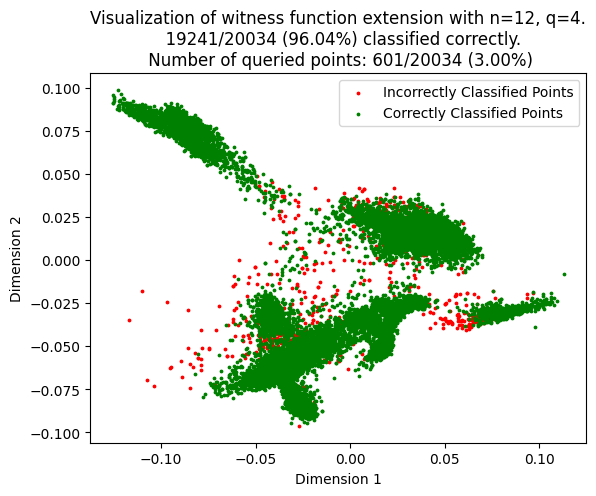

In [79]:
plt.scatter(trainsph[np.where(truthcheck2==False)[0],1],trainsph[np.where(truthcheck2==False)[0],2],s=3,color="r",label=f"Incorrectly Classified Points")
plt.scatter(trainsph[np.where(truthcheck2)[0],1],trainsph[np.where(truthcheck2)[0],2],color="g",s=3,label=f"Correctly Classified Points")
plt.title(f'Visualization of witness function extension with n={new_n}, q={dim}.\n  {correctnum2}/{trainsize} ({100*correctnum2/trainsize:.2f}%) classified correctly.\n Number of queried points: {np.round(trainsize*quota_percentage).astype(int)}/{trainsize} ({100*(np.round(trainsize*quota_percentage)/trainsize):.2f}%)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

# Show the plot
plt.show()

Generate confusion matrix.

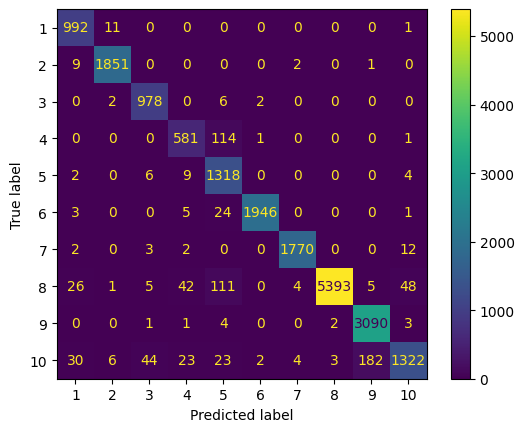

In [80]:
conf_matrix=metrics.confusion_matrix(target,final_labels)
disp=metrics.ConfusionMatrixDisplay(conf_matrix,display_labels=labels.astype(int))
disp.plot()

Generate predicted labels scatterplot.

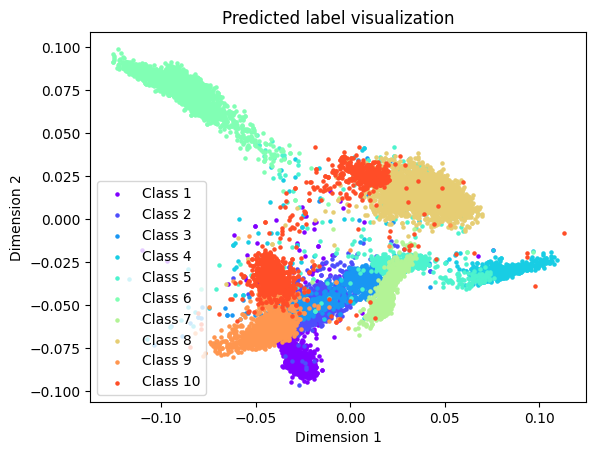

In [81]:
c=cm.rainbow(np.linspace(0,1,len(classes)+1))
for i in classes:
    plt.scatter(trainsph[np.where(final_labels==i)[0],1],trainsph[np.where(final_labels==i)[0],2],s=5,color=c[i-1],label=f"Class {i}")
plt.title('Predicted label visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

# Show the plot
plt.show()

Visualize heatmap of witness function.

Text(0, 0.5, 'Dimension 2')

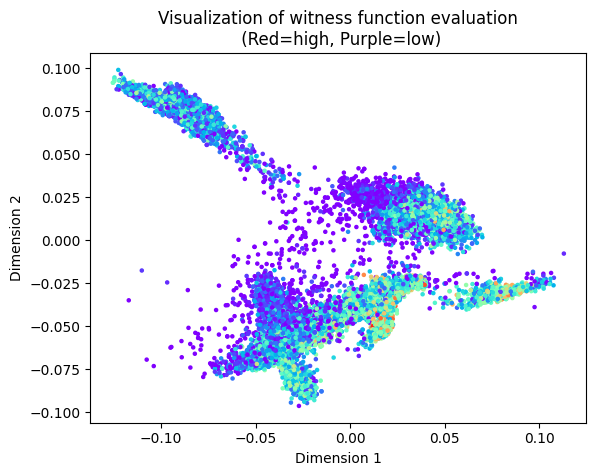

In [82]:
c=cm.rainbow(kernel_max/np.max(kernel_max))
plt.scatter(trainsph[remainderpoints,1],trainsph[remainderpoints,2],s=5,color=c)
plt.title('Visualization of witness function evaluation\n (Red=high, Purple=low)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Generate Figure to show accuracy for varying number of samples

(Only need to run this cell if Phimat is not already in memory)

In [ ]:
n=128

#Phi function
#Phimat=Phi(n,sphmat)
#Phisum=np.sum(Phimat,axis=0)

Phimat=Phiapprox(n,sphmat,100)
Phisum=np.sum(Phimat,axis=0)

Unlike the witness function section, the next cell will generate the Phiqmat matrix for every data point, taking longer to run. This is so we can adaptively call the columns of this matrix as we go through the SCALe algorithm for different numbers of queries.

In [ ]:
dim=4
new_n=12

Phiqmat=Phiqapprox(new_n,dim,sphmat,100)

Adjusted code to implement SCALe, while stopping at certain sample thresholds to do witness function and generate model accuracy outputs.

In [12]:
predict_labels=np.zeros(trainsize)
A=[]
B=[]
xvals=[]
yvals=[]
Asize=0

for eta in np.arange(.21,.27,.005):
    #Adjacency matrix for sheared points
    adjmat=np.zeros([verticescount, verticescount])
    adjmat[distmat_sheared<eta]=1
    adjmat=adjmat-np.identity(len(vertex_list))

    #Compute Graph components
    graph=csr_matrix(adjmat)
    num_components, componentlist = connected_components(csgraph=graph, directed=False, return_labels=True)

    #Trim components. Any components of size smaller than this value will be removed from list by setting their component to -1
    componentthreshold=3
    componentnum, componentsizes=np.unique(componentlist, return_counts="True")
    bigcomponents=np.where(componentsizes>componentthreshold)[0]
    sheared_componentlist=componentlist[np.isin(componentlist,bigcomponents)]
    sheared_componentnum, sheared_componentsizes=np.unique(sheared_componentlist, return_counts="True")

    #Find modal points in each cluster to query true class label. keep track of x_i and y_i from each.
    for i in sheared_componentnum: # np.arange(0,num_components):
        componentset=vertex_list[np.where(componentlist==i)[0]]
        if np.intersect1d(A,componentset).size==0:

            x_i=componentset[np.argmax(Phisum[componentset])]
            y_i=target[x_i]
            A.append(x_i)
            B.append(y_i)
            predict_labels[componentset]=y_i

            #uncomment this code and comment the above code to query multiple points per cluster
            # querysize=np.max((round(componentset.size*.05),1))
            # queryargs=np.argpartition(Phisum[componentset], -querysize)[-querysize:]
            # modalpoint=stats.mode(target[componentset[queryargs]])[0]
            # y_i=modalpoint
            # for x_i in componentset[queryargs]:
            #     A.append(x_i)
            #     B.append(target[x_i])
            #     predict_labels[x_i]=target[x_i]
            # predict_labels[np.setdiff1d(componentset,componentset[queryargs])]=y_i
            
        elif np.size(np.unique(np.intersect1d(A,componentset)))==1:
            predict_labels[componentset]=target[np.unique(np.intersect1d(A,componentset))[0]]

    if len(A)>Asize+10:
        xvals.append(len(A))
        Asize=len(A)
        final_labels=copy.deepcopy(predict_labels)
        remainderpoints=np.where(final_labels==0)[0]
        labels=np.setdiff1d(np.sort(list(dict.fromkeys(final_labels))),[0])

        #initialization of clusters and witness function
        S=[]
        witness=[]
        Phimat_sheared=Phiqmat[:,remainderpoints]
        for i in np.arange(0,len(labels)):
            S.append(np.where(final_labels==labels[i])[0])
            witness.append(np.sum(Phimat_sheared[S[i]],axis=0)/len(S[i]))

        #this calculates the indices from the labels set that should be applied to each of the remainder points
        newlabel_indices=np.argmax(np.concatenate(witness).reshape(len(labels),len(remainderpoints)), axis=0)
        kernel_max=np.max(np.concatenate(witness).reshape(len(labels),len(remainderpoints)), axis=0)

        #create final_labels and add the new labels to it.
        final_labels[remainderpoints]=labels[newlabel_indices]

        truthcheck2=target==final_labels
        yvals.append(len(np.where(truthcheck2)[0]))

print(xvals)
print(yvals)

[11, 36, 52, 85, 122, 152, 178, 202, 221, 240, 254]
[10120, 15089, 15455, 15898, 18898, 18977, 19006, 19230, 19287, 19298, 19253]


Plot values.

[50.5141259858241, 75.31696116601778, 77.14385544574223, 79.35509633622841, 94.32963961265848, 94.72396925227113, 94.86872317060997, 95.98682240191674, 96.27133872416891, 96.32624538284915, 96.1016272337027]


Text(0, 0.5, 'Accuracy')

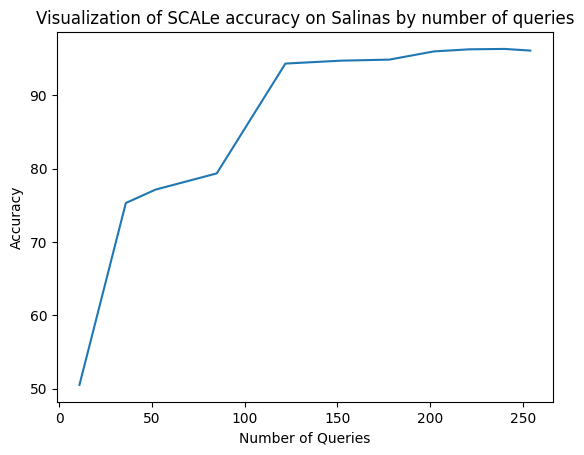

In [18]:
yvalspercent=[100*y / trainsize for y in yvals]
print(yvalspercent)
plt.plot(xvals,yvalspercent)
plt.title('Visualization of SCALe accuracy on Salinas by number of queries')
plt.xlabel('Number of Queries')
plt.ylabel('Accuracy')